# Notebook 03e: Outlier Detection & Final Filtering

**Autor:** Silas Pignotti  
**Datum:** Januar 2026  
**Version:** 1.0

---

## 1. OVERVIEW & METHODOLOGY

### 1.1 Purpose

This notebook performs **comprehensive outlier detection** using three independent methods to identify anomalous trees that should be excluded from model training. The analysis uses:

1. **Spectral Outliers (Univariate):** Z-Score method to detect extreme values in individual features
2. **Spectral Outliers (Multivariate):** Mahalanobis Distance to detect unusual feature combinations
3. **Structural Outliers:** IQR method on CHM features to detect implausible tree heights

**Key Innovation:** Hierarchical decision logic combines all three methods with different confidence levels:
- **CRITICAL** (remove): High confidence anomalies (Mahalanobis + at least one other method)
- **HIGH** (flag, keep): 2-of-3 methods agree
- **MEDIUM** (flag, keep): Only 1 method flags
- **CLEAN** (keep): No flags

**Final Step:** Sample size filtering ensures all genera have sufficient samples for robust training.

**Input:** Correlation-reduced datasets from 03d_correlation_analysis.ipynb  
**Output:** Training-ready datasets with outliers removed and sample size constraints met

### 1.2 Workflow

```
[PHASE 1: DATA LOADING & VALIDATION]
├── Step 1.1: Load correlation-reduced datasets
├── Step 1.2: Classify features (Spectral, CHM, Metadata)
└── Step 1.3: Data quality checks (NaNs, types)

↓

[PHASE 2: SPECTRAL OUTLIERS - UNIVARIATE (Z-Score)]
├── Step 2.1: Calculate Z-scores for all spectral features
├── Step 2.2: Count features with |z| > 3 per tree
├── Step 2.3: Flag trees with ≥10 extreme features
└── Step 2.4: Visualize distribution

↓

[PHASE 3: SPECTRAL OUTLIERS - MULTIVARIATE (Mahalanobis)]
├── Step 3.1: Calculate Mahalanobis Distance (per genus)
├── Step 3.2: Determine χ² threshold (α=0.001)
├── Step 3.3: Flag trees with D² > threshold
└── Step 3.4: Visualize genus-specific distributions

↓

[PHASE 4: STRUCTURAL OUTLIERS (CHM IQR)]
├── Step 4.1: Calculate IQR per genus & city
├── Step 4.2: Define outlier bounds (Q1-1.5*IQR, Q3+1.5*IQR)
├── Step 4.3: Flag trees outside bounds
└── Step 4.4: Visualize genus-city height distributions

↓

[PHASE 5: HIERARCHICAL DECISION LOGIC]
├── Step 5.1: Combine 3 flags into outlier levels
│   ├── CRITICAL: mahalanobis & (zscore | chm)
│   ├── HIGH: 2-of-3 flags (not CRITICAL)
│   ├── MEDIUM: exactly 1 flag
│   └── CLEAN: no flags
├── Step 5.2: Remove CRITICAL outliers
└── Step 5.3: Document removal statistics

↓

[PHASE 6: SAMPLE SIZE FILTERING]
├── Step 6.1: Count trees per genus (after outlier removal)
├── Step 6.2: Apply minimum thresholds
│   ├── ≥1500 total per genus
│   └── ≥500 per city for cross-city genera
├── Step 6.3: Remove non-viable genera
└── Step 6.4: Document final genus list

↓

[PHASE 7: FINAL VALIDATION & SUMMARY]
├── Step 7.1: Dataset statistics (before/after)
├── Step 7.2: Genus distribution table
├── Step 7.3: Class imbalance report
└── Step 7.4: Data quality assertions

↓

[PHASE 8: EXPORT]
├── Step 8.1: Export training-ready GeoPackages
├── Step 8.2: Export metadata & reports
└── Step 8.3: Export visualizations

↓

[OUTPUT]
├── trees_final_no_edge.gpkg
├── trees_final_20m_edge.gpkg
├── outlier_detection_report.json
├── sample_size_filter_report.csv
├── final_dataset_summary.json
└── visualizations/*.png
```

### 1.3 Expected Outputs

| File | Type | Description |
|------|------|-------------|
| `trees_final_*.gpkg` | GeoPackage | **TRAINING-READY** datasets (2 variants) |
| `outlier_detection_report.json` | JSON | All outlier statistics + decisions |
| `sample_size_filter_report.csv` | CSV | Genus-level filtering decisions |
| `final_dataset_summary.json` | JSON | Final counts, features, class imbalance |
| `outlier_zscore_distribution.png` | PNG | Z-Score outlier histogram |
| `outlier_mahalanobis_scatter.png` | PNG | Mahalanobis D² scatter |
| `outlier_chm_boxplots.png` | PNG | CHM distribution with IQR bounds |
| `outlier_venn_diagram.png` | PNG | Overlap of 3 outlier methods |
| `genus_distribution_final.png` | PNG | Final genus distribution stacked bar |

### 1.4 Theoretical Background

#### **Why Three Independent Methods?**

**1. Z-Score (Univariate Spectral):**
- **Detects:** Extreme values in individual features
- **Example:** B02 = 0 (sensor error) or NDVI = -0.5 (water/shadow)
- **Formula:** $z = \frac{x - \mu}{\sigma}$, threshold |z| > 3
- **Limitation:** Misses multivariate patterns (unusual combinations of normal values)

**2. Mahalanobis Distance (Multivariate Spectral):**
- **Detects:** Unusual feature combinations (even if individual features are normal)
- **Example:** NDVI=0.7 (normal) + B08=5000 (normal) but combination unusual for QUERCUS
- **Formula:** $D^2 = (x - \mu)^T \Sigma^{-1} (x - \mu)$
- **Threshold:** χ²(p, α=0.001) where p = number of features
- **Strength:** Accounts for correlations between features
- **Limitation:** Assumes multivariate normal distribution

**3. IQR Method (Structural CHM):**
- **Detects:** Implausible tree heights (genus & city specific)
- **Formula:** Outliers if `height_m < Q1 - 1.5*IQR` or `height_m > Q3 + 1.5*IQR`
- **Strength:** Robust to skewed distributions, handles city-specific offsets
- **Limitation:** Only captures height anomalies, not spectral issues

#### **Why CHM Separate from Mahalanobis?**

**Different Physical Domains:**
- Spectral: Reflectance (leaf chemistry) - Sentinel-2
- CHM: Structure (tree height) - LiDAR
- **Not comparable:** Like mixing meters with percentages

**Different Error Sources:**
- Spectral: Clouds, shadows, atmospheric effects
- CHM: GPS errors, DGM artifacts, mixed pixels
- **Uncorrelated:** Spectrally normal tree can have wrong height (GPS error)

**Different Distributions:**
- Spectral features: Approximately normal
- CHM height_m: Right-skewed (many small, few large trees)
- **Mahalanobis assumption violated** if CHM included

**Feature Imbalance:**
- Spectral: ~130-140 features
- CHM: 1-3 features
- **CHM would be dominated** in combined Mahalanobis (2% of features)

#### **Hierarchical Decision Logic**

**CRITICAL (remove):**
- `mahalanobis_outlier == True` AND (`zscore_outlier == True` OR `chm_outlier == True`)
- **Rationale:** Mahalanobis is strongest indicator (multivariate spectral anomaly)
- Plus additional evidence (univariate extreme OR structural anomaly)
- **High confidence:** Fundamental problem with tree data

**HIGH/MEDIUM (flag, keep):**
- Could be natural biological variation
- Example: Very old tree (CHM outlier) but spectrally healthy
- Keep for potential experiments: "What if we also remove HIGH?"

**Expected Removal Rate:** ~1.5-2.5% (very conservative)

---

## 2. SETUP & IMPORTS

In [1]:
# Core packages
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import json
import warnings
from datetime import datetime
import gc

# Statistical analysis
from scipy import stats
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3

warnings.filterwarnings('ignore')

print("✓ Imports successful")

✓ Imports successful


In [2]:
# Google Colab: Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.1 Path Configuration

In [3]:
import shutil

# Base paths
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")
DATA_DIR = BASE_DIR / 'data'

# Input: Correlation-reduced datasets (from Drive)
DRIVE_INPUT_DATA_DIR = DATA_DIR / '02_pipeline' / '04_feature_reduction' / '04_correlation_analysis' / 'data'

# Output: Final training-ready datasets (to Drive)
DRIVE_BASE_OUTPUT_DIR = DATA_DIR / '02_pipeline' / '04_feature_reduction' / '05_outlier_detection'
DRIVE_OUTPUT_DATA_DIR = DRIVE_BASE_OUTPUT_DIR / 'data'
DRIVE_OUTPUT_METADATA_DIR = DRIVE_BASE_OUTPUT_DIR / 'metadata'
DRIVE_OUTPUT_FIGURES_DIR = DRIVE_BASE_OUTPUT_DIR / 'plots'

# Local runtime paths (for faster I/O)
LOCAL_BASE_DIR = Path('/content/local_data') # Using /content/local_data to avoid conflicts and keep structured
LOCAL_INPUT_DIR = LOCAL_BASE_DIR / 'input'
LOCAL_OUTPUT_DIR = LOCAL_BASE_DIR / 'output'
LOCAL_OUTPUT_METADATA_DIR = LOCAL_OUTPUT_DIR / 'metadata'
LOCAL_OUTPUT_FIGURES_DIR = LOCAL_OUTPUT_DIR / 'figures'

# Create all necessary directories
DRIVE_OUTPUT_DATA_DIR.mkdir(parents=True, exist_ok=True)
DRIVE_OUTPUT_METADATA_DIR.mkdir(parents=True, exist_ok=True)
DRIVE_OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

LOCAL_INPUT_DIR.mkdir(parents=True, exist_ok=True)
LOCAL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
LOCAL_OUTPUT_METADATA_DIR.mkdir(parents=True, exist_ok=True)
LOCAL_OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# --- ALIASES FOR COMPATIBILITY ---
# Heavy data -> Local Runtime (fast I/O)
OUTPUT_DATA_DIR = LOCAL_OUTPUT_DIR

# Lightweight files -> Direct to Drive (simplicity)
OUTPUT_METADATA_DIR = DRIVE_OUTPUT_METADATA_DIR
OUTPUT_FIGURES_DIR = DRIVE_OUTPUT_FIGURES_DIR

print(f"✓ Paths configured")
print(f"  Drive Input:  {DRIVE_INPUT_DATA_DIR}")
print(f"  Drive Output: {DRIVE_OUTPUT_DATA_DIR}")
print(f"  Local Input:  {LOCAL_INPUT_DIR}")
print(f"  Local Output: {LOCAL_OUTPUT_DIR}")

✓ Paths configured
  Drive Input:  /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/04_feature_reduction/04_correlation_analysis/data
  Drive Output: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/04_feature_reduction/05_outlier_detection/data
  Local Input:  /content/local_data/input
  Local Output: /content/local_data/output


### 2.2 Visualization Setup

In [4]:
# Publication-ready style
plt.rcdefaults()
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

print("✓ Visualization style configured")

✓ Visualization style configured


### 2.3 Configuration & Thresholds

In [5]:
# Outlier Detection Thresholds
ZSCORE_THRESHOLD = 3.0                  # |z| > 3 (99.7% of normal distribution)
ZSCORE_MIN_FEATURES = 10                # Minimum features with extreme z-score
MAHALANOBIS_ALPHA = 0.0001               # χ² significance level
CHM_IQR_FACTOR = 1.5                    # IQR multiplier (Tukey's rule)

# Sample Size Thresholds
MIN_TOTAL_PER_GENUS = 1500              # Minimum total trees per genus
MIN_PER_CITY = 500                      # Minimum trees per city (for cross-city)

print("Outlier Detection Configuration:")
print(f"  Z-Score threshold: {ZSCORE_THRESHOLD}")
print(f"  Z-Score min features: {ZSCORE_MIN_FEATURES}")
print(f"  Mahalanobis α: {MAHALANOBIS_ALPHA}")
print(f"  CHM IQR factor: {CHM_IQR_FACTOR}")
print(f"\nSample Size Constraints:")
print(f"  Min total per genus: {MIN_TOTAL_PER_GENUS}")
print(f"  Min per city: {MIN_PER_CITY}")

Outlier Detection Configuration:
  Z-Score threshold: 3.0
  Z-Score min features: 10
  Mahalanobis α: 0.0001
  CHM IQR factor: 1.5

Sample Size Constraints:
  Min total per genus: 1500
  Min per city: 500


---

## 3. PHASE 1: DATA LOADING & VALIDATION

In [6]:
print("Preparing data...\n")

# Copy from Drive to Local if needed
input_files = ['trees_correlation_reduced_no_edge.gpkg', 'trees_correlation_reduced_20m_edge.gpkg']

for filename in input_files:
    source = DRIVE_INPUT_DATA_DIR / filename
    dest = LOCAL_INPUT_DIR / filename

    if not dest.exists():
        print(f"  Copying {filename} to local runtime...")
        if source.exists():
            shutil.copy(source, dest)
        else:
            print(f"  ⚠️ WARNING: Source file not found: {source}")
    else:
        print(f"  {filename} already exists locally.")

print("\nLoading correlation-reduced datasets...")

# Load datasets from Local Runtime
trees_no_edge = gpd.read_file(LOCAL_INPUT_DIR / 'trees_correlation_reduced_no_edge.gpkg')
print(f"✓ Loaded no-edge: {len(trees_no_edge):,} trees, {len(trees_no_edge.columns)} columns")

trees_20m_edge = gpd.read_file(LOCAL_INPUT_DIR / 'trees_correlation_reduced_20m_edge.gpkg')
print(f"✓ Loaded 20m-edge: {len(trees_20m_edge):,} trees, {len(trees_20m_edge.columns)} columns")

print(f"\nDataset info:")
print(f"  Cities: {sorted(trees_no_edge['city'].unique())}")
print(f"  Genera (no-edge): {trees_no_edge['genus_latin'].nunique()}")
print(f"  Genera (20m-edge): {trees_20m_edge['genus_latin'].nunique()}")

Preparing data...

  Copying trees_correlation_reduced_no_edge.gpkg to local runtime...
  Copying trees_correlation_reduced_20m_edge.gpkg to local runtime...

Loading correlation-reduced datasets...
✓ Loaded no-edge: 714,676 trees, 153 columns
✓ Loaded 20m-edge: 289,525 trees, 153 columns

Dataset info:
  Cities: ['Berlin', 'Hamburg', 'Rostock']
  Genera (no-edge): 19
  Genera (20m-edge): 19


### 3.1 Feature Classification

In [7]:
# --- TEMPORARY CELL: Remove crown_ratio ---
# User Request: crown_ratio is not good. Remove it here temporarily.
# This cell can be deleted later when the feature is removed upstream.

print("TEMPORARY: Removing 'crown_ratio' from datasets...")

cols_to_remove = ['crown_ratio']

# Remove from no-edge
for col in cols_to_remove:
    if col in trees_no_edge.columns:
        trees_no_edge.drop(columns=[col], inplace=True)
        print(f"  Removed '{col}' from no-edge dataset")

# Remove from 20m-edge
for col in cols_to_remove:
    if col in trees_20m_edge.columns:
        trees_20m_edge.drop(columns=[col], inplace=True)
        print(f"  Removed '{col}' from 20m-edge dataset")

print("\u2713 Temporary removal complete.")

TEMPORARY: Removing 'crown_ratio' from datasets...
  Removed 'crown_ratio' from no-edge dataset
  Removed 'crown_ratio' from 20m-edge dataset
✓ Temporary removal complete.


In [8]:
print("\nFeature Classification & Data Quality...\n")

# --- 1. Classify Features ---
# Metadata columns
metadata_candidates = ['tree_id', 'genus_latin', 'city', 'species_group', 'tree_type', 'geometry']
metadata_cols = [col for col in metadata_candidates if col in trees_no_edge.columns]

# CHM features
# Note: 'crown_ratio' removed from candidates as per user request
chm_candidates = ['height_m', 'height_m_norm', 'height_m_percentile']
chm_cols = [col for col in trees_no_edge.columns if col in chm_candidates]

# Spectral features (all others)
spectral_cols = [col for col in trees_no_edge.columns
                if col not in metadata_cols and col not in chm_cols]

print(f"Feature Classification:")
print(f"  Metadata ({len(metadata_cols)}): {', '.join(metadata_cols)}")
print(f"  CHM ({len(chm_cols)}): {', '.join(chm_cols)}")

# --- 2. Spectral Analysis ---
print(f"\nSpectral Feature Analysis ({len(spectral_cols)} columns):")

spectral_bases = set()
months = set()

for col in spectral_cols:
    parts = col.split('_')
    if len(parts) > 1 and parts[-1].isdigit():
        month = parts[-1]
        base = "_".join(parts[:-1])
        months.add(month)
        spectral_bases.add(base)
    else:
        spectral_bases.add(col)

print(f"  Base Bands ({len(spectral_bases)}): {', '.join(sorted(spectral_bases))}")
print(f"  Months ({len(months)}): {', '.join(sorted(months))}")

# Completeness Check
missing_combinations = []
for base in spectral_bases:
    for month in months:
        expected_col = f"{base}_{month}"
        if expected_col not in spectral_cols:
            missing_combinations.append(expected_col)

if missing_combinations:
    print(f"  ⚠️ WARNING: Missing band-month combinations: {missing_combinations}")
else:
    print(f"  ✓ Completeness Check: All {len(spectral_bases)} bands exist for all {len(months)} months.")

# --- 3. Final NaN Check (Features Only) ---
print(f"\nFinal NaN Check (Features only):")

features_to_check = spectral_cols + chm_cols
nan_counts = trees_no_edge[features_to_check].isna().sum()
cols_with_nans = nan_counts[nan_counts > 0]

if len(cols_with_nans) > 0:
    print(f"  ⚠️  WARNING: Found NaN values in feature columns:")
    for col, count in cols_with_nans.items():
        print(f"    - {col}: {count} NaNs")
else:
    print(f"  ✓ No NaN values found in {len(features_to_check)} feature columns (Spectral + CHM).")


Feature Classification & Data Quality...

Feature Classification:
  Metadata (5): tree_id, genus_latin, city, tree_type, geometry
  CHM (3): height_m, height_m_norm, height_m_percentile

Spectral Feature Analysis (144 columns):
  Base Bands (18): B02, B04, B05, B06, B08, B11, B12, B8A, CIre, EVI, IRECI, NDII, NDVI, NDVIre, NDWI, NDre1, RTVIcore, VARI
  Months (8): 03, 04, 05, 06, 07, 08, 09, 10
  ✓ Completeness Check: All 18 bands exist for all 8 months.

Final NaN Check (Features only):
  ✓ No NaN values found in 147 feature columns (Spectral + CHM).


---

## 4. PHASE 2: SPECTRAL OUTLIERS - UNIVARIATE (Z-Score)

### 4.1 Calculate Z-Scores for All Spectral Features

In [9]:
def calculate_zscore_outliers(df, spectral_features, threshold=ZSCORE_THRESHOLD,
                              min_features=ZSCORE_MIN_FEATURES):
    """
    Calculate Z-score outliers.

    A tree is flagged if >= min_features have |z| > threshold.

    Returns:
        pd.Series: Boolean mask (True = outlier)
    """
    print(f"\n{'='*60}")
    print(f"Z-SCORE OUTLIER DETECTION")
    print(f"{'='*60}\n")

    print(f"  Features analyzed: {len(spectral_features)}")
    print(f"  Threshold: |z| > {threshold}")
    print(f"  Min features required: {min_features}")

    # Calculate z-scores (ignoring NaNs)
    z_scores = np.abs(stats.zscore(df[spectral_features], nan_policy='omit'))

    # Count features with extreme z-scores per tree
    extreme_count = (z_scores > threshold).sum(axis=1)

    # Flag trees with >= min_features extreme
    outlier_mask = extreme_count >= min_features

    print(f"\n  Results:")
    print(f"    Trees flagged: {outlier_mask.sum():,} ({outlier_mask.sum()/len(df)*100:.2f}%)")
    print(f"    Mean extreme features (flagged trees): {extreme_count[outlier_mask].mean():.1f}")
    print(f"    Max extreme features: {extreme_count.max()}")

    return outlier_mask, extreme_count


# Calculate for both datasets
zscore_outlier_no, zscore_count_no = calculate_zscore_outliers(
    trees_no_edge, spectral_cols
)

zscore_outlier_20m, zscore_count_20m = calculate_zscore_outliers(
    trees_20m_edge, spectral_cols
)

# Add to datasets
trees_no_edge['zscore_outlier'] = zscore_outlier_no
trees_no_edge['zscore_extreme_count'] = zscore_count_no

trees_20m_edge['zscore_outlier'] = zscore_outlier_20m
trees_20m_edge['zscore_extreme_count'] = zscore_count_20m


Z-SCORE OUTLIER DETECTION

  Features analyzed: 144
  Threshold: |z| > 3.0
  Min features required: 10

  Results:
    Trees flagged: 13,744 (1.92%)
    Mean extreme features (flagged trees): 14.3
    Max extreme features: 61

Z-SCORE OUTLIER DETECTION

  Features analyzed: 144
  Threshold: |z| > 3.0
  Min features required: 10

  Results:
    Trees flagged: 6,307 (2.18%)
    Mean extreme features (flagged trees): 14.1
    Max extreme features: 49


### 4.2 Visualize Z-Score Distribution

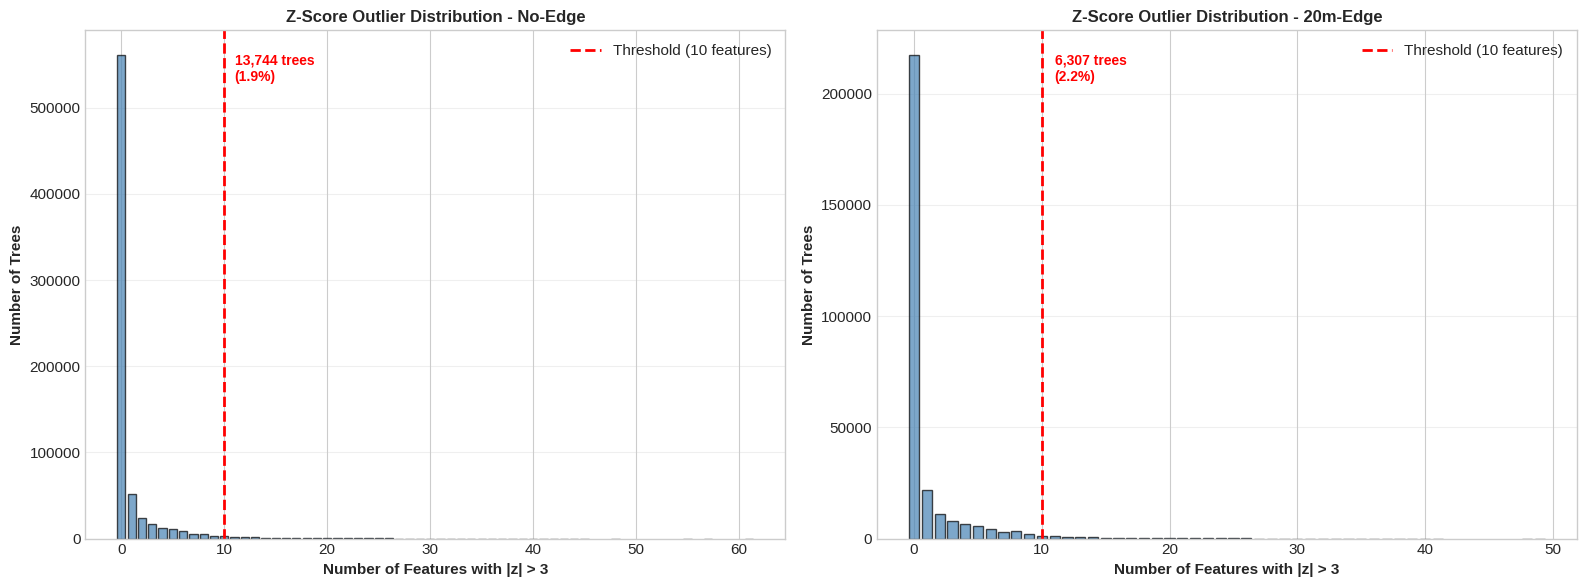

✓ Z-Score distribution plot saved


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (df, title) in enumerate([(trees_no_edge, 'No-Edge'),
                                    (trees_20m_edge, '20m-Edge')]):
    ax = axes[idx]

    # Histogram of extreme feature counts
    counts = df['zscore_extreme_count'].value_counts().sort_index()

    ax.bar(counts.index, counts.values, color='steelblue', alpha=0.7, edgecolor='black')

    # Mark threshold
    ax.axvline(ZSCORE_MIN_FEATURES, color='red', linestyle='--', linewidth=2,
              label=f'Threshold ({ZSCORE_MIN_FEATURES} features)')

    # Annotate outlier zone
    outlier_count = (df['zscore_extreme_count'] >= ZSCORE_MIN_FEATURES).sum()
    ax.text(ZSCORE_MIN_FEATURES + 1, ax.get_ylim()[1] * 0.9,
           f'{outlier_count:,} trees\n({outlier_count/len(df)*100:.1f}%)',
           fontsize=10, color='red', fontweight='bold')

    ax.set_xlabel('Number of Features with |z| > 3', fontsize=11, fontweight='bold')
    ax.set_ylabel('Number of Trees', fontsize=11, fontweight='bold')
    ax.set_title(f'Z-Score Outlier Distribution - {title}',
                fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES_DIR / 'outlier_zscore_distribution.png',
           dpi=300, bbox_inches='tight')
plt.show()

print("✓ Z-Score distribution plot saved")

---

## 5. PHASE 3: SPECTRAL OUTLIERS - MULTIVARIATE (Mahalanobis Distance)

### 5.1 Calculate Mahalanobis Distance (Genus-Specific)

In [11]:
def calculate_mahalanobis_outliers(df, spectral_features, alpha=MAHALANOBIS_ALPHA):
    """
    Calculate Mahalanobis Distance outliers (genus-specific).

    For each genus:
    - Calculate D² for all trees in that genus
    - Threshold: χ²(p, 1-α) where p = number of features

    Returns:
        pd.Series: Boolean mask (True = outlier)
        pd.Series: D² values
        pd.DataFrame: Statistics per genus
    """
    print(f"\n{'='*60}")
    print(f"MAHALANOBIS DISTANCE OUTLIER DETECTION")
    print(f"{'='*60}\n")

    print(f"  Features analyzed: {len(spectral_features)}")
    print(f"  Significance level α: {alpha}")
    print(f"  Method: Genus-specific (separate for each genus)")

    # Initialize
    outlier_mask = pd.Series(False, index=df.index)
    d_squared = pd.Series(np.nan, index=df.index)

    # Calculate threshold
    p = len(spectral_features)
    threshold = chi2.ppf(1 - alpha, df=p)

    print(f"  χ² threshold (p={p}, α={alpha}): {threshold:.2f}")
    print(f"\n  Per-Genus Analysis:")

    genus_stats = []

    for genus in df['genus_latin'].unique():
        genus_mask = df['genus_latin'] == genus
        genus_data = df.loc[genus_mask, spectral_features]

        if len(genus_data) < p + 2:  # Need more samples than features
            print(f"    {genus}: Skipped (n={len(genus_data)} < {p+2})")
            continue

        # Calculate mean and covariance (as NumPy arrays!)
        mean_vec = genus_data.mean().values
        cov_matrix = genus_data.cov().values

        try:
            inv_cov = np.linalg.inv(cov_matrix)
        except np.linalg.LinAlgError:
            print(f"    {genus}: Skipped (singular covariance matrix)")
            continue

        # VECTORIZED: Calculate D² for all trees at once
        diff_matrix = genus_data.values - mean_vec
        d2_values = np.sum((diff_matrix @ inv_cov) * diff_matrix, axis=1)

        # Store results
        d_squared.loc[genus_data.index] = d2_values
        outlier_mask.loc[genus_data.index] = d2_values > threshold

        # Statistics
        genus_outliers = (d2_values > threshold).sum()
        genus_pct = (genus_outliers / len(genus_data)) * 100

        genus_stats.append({
            'genus': genus,
            'n': len(genus_data),
            'outliers': genus_outliers,
            'pct': genus_pct,
            'mean_d2': float(d2_values.mean()),  # Explicit float conversion
            'max_d2': float(d2_values.max())
        })

        print(f"    {genus:12s}: n={len(genus_data):6,} | "
              f"outliers={genus_outliers:4,} ({genus_pct:4.1f}%) | "
              f"mean D²={float(d2_values.mean()):6.1f} | "
              f"max D²={float(d2_values.max()):8.0f}")

    print(f"\n  Overall Results:")
    print(f"    Trees flagged: {outlier_mask.sum():,} ({outlier_mask.sum()/len(df)*100:.2f}%)")

    return outlier_mask, d_squared, pd.DataFrame(genus_stats)


# Calculate for both datasets
mahal_outlier_no, d2_no, genus_stats_no = calculate_mahalanobis_outliers(
    trees_no_edge, spectral_cols
)

mahal_outlier_20m, d2_20m, genus_stats_20m = calculate_mahalanobis_outliers(
    trees_20m_edge, spectral_cols
)

# Add to datasets
trees_no_edge['mahalanobis_outlier'] = mahal_outlier_no
trees_no_edge['mahalanobis_d2'] = d2_no

trees_20m_edge['mahalanobis_outlier'] = mahal_outlier_20m
trees_20m_edge['mahalanobis_d2'] = d2_20m

# VERIFICATION: Check if mean_d2 values are stored correctly
print("\n" + "="*60)
print("VERIFICATION: Stored Statistics")
print("="*60)
print("\nNo-Edge Dataset - Mean D² per Genus:")
print(genus_stats_no[['genus', 'mean_d2', 'max_d2']].to_string(index=False))
print(f"\n20m-Edge Dataset - Mean D² per Genus:")
print(genus_stats_20m[['genus', 'mean_d2', 'max_d2']].to_string(index=False))


MAHALANOBIS DISTANCE OUTLIER DETECTION

  Features analyzed: 144
  Significance level α: 0.0001
  Method: Genus-specific (separate for each genus)
  χ² threshold (p=144, α=0.0001): 215.81

  Per-Genus Analysis:
    QUERCUS     : n=103,953 | outliers=9,071 ( 8.7%) | mean D²= 144.0 | max D²=  103730
    BETULA      : n=31,554 | outliers=3,063 ( 9.7%) | mean D²= 144.0 | max D²=   31541
    ULMUS       : n=12,007 | outliers=1,211 (10.1%) | mean D²= 144.0 | max D²=   10616
    ACER        : n=160,450 | outliers=14,108 ( 8.8%) | mean D²= 144.0 | max D²=  159296
    FRAXINUS    : n=21,690 | outliers=2,379 (11.0%) | mean D²= 144.0 | max D²=   21637
    POPULUS     : n=21,688 | outliers=2,285 (10.5%) | mean D²= 144.0 | max D²=   11981
    TILIA       : n=180,581 | outliers=16,272 ( 9.0%) | mean D²= 144.0 | max D²=  180506
    AESCULUS    : n=28,378 | outliers=2,892 (10.2%) | mean D²= 144.0 | max D²=   28375
    SALIX       : n= 8,598 | outliers= 996 (11.6%) | mean D²= 144.0 | max D²=    7775
 

### 5.2 Visualize Mahalanobis Distance Distribution

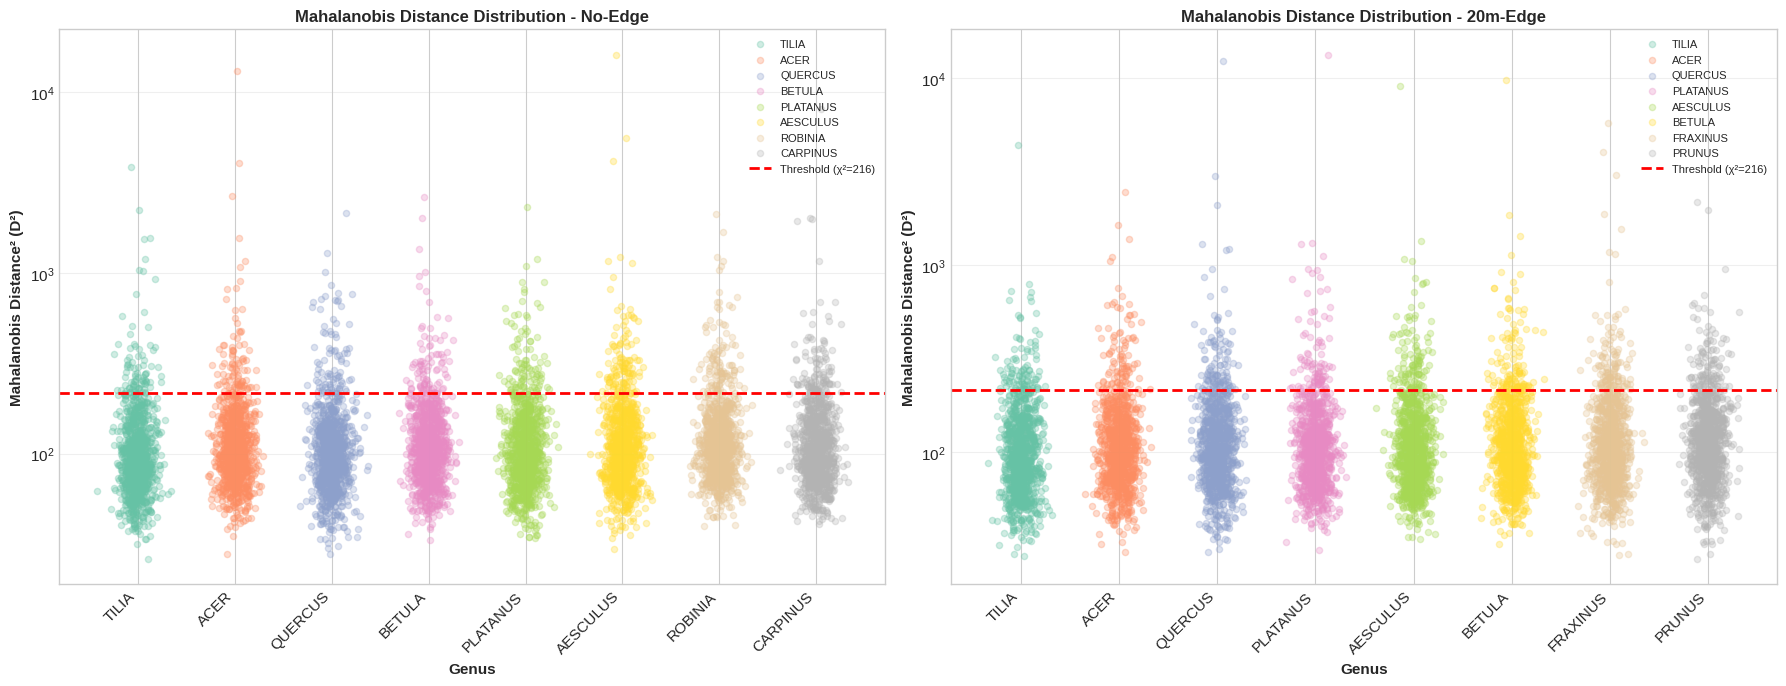

✓ Mahalanobis scatter plot saved


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Calculate threshold for visualization
threshold = chi2.ppf(1 - MAHALANOBIS_ALPHA, df=len(spectral_cols))

for idx, (df, title, genus_stats) in enumerate([
    (trees_no_edge, 'No-Edge', genus_stats_no),
    (trees_20m_edge, '20m-Edge', genus_stats_20m)
]):
    ax = axes[idx]

    # Get top 8 genera by sample size
    top_genera = df['genus_latin'].value_counts().head(8).index

    # Plot D² per genus
    for genus in top_genera:
        genus_data = df[df['genus_latin'] == genus]
        d2_values = genus_data['mahalanobis_d2'].dropna()

        if len(d2_values) > 0:
            # Sample for visualization (avoid overcrowding)
            if len(d2_values) > 1000:
                d2_sample = d2_values.sample(n=1000, random_state=42)
            else:
                d2_sample = d2_values

            # Scatter with jitter
            x_jitter = np.random.normal(0, 0.1, size=len(d2_sample))
            genus_idx = list(top_genera).index(genus)

            ax.scatter(genus_idx + x_jitter, d2_sample,
                      alpha=0.3, s=20, label=genus)

    # Threshold line
    ax.axhline(threshold, color='red', linestyle='--', linewidth=2,
              label=f'Threshold (χ²={threshold:.0f})')

    ax.set_xticks(range(len(top_genera)))
    ax.set_xticklabels(top_genera, rotation=45, ha='right')
    ax.set_xlabel('Genus', fontsize=11, fontweight='bold')
    ax.set_ylabel('Mahalanobis Distance² (D²)', fontsize=11, fontweight='bold')
    ax.set_title(f'Mahalanobis Distance Distribution - {title}',
                fontsize=12, fontweight='bold')
    ax.set_yscale('log')  # Log scale for better visibility
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES_DIR / 'outlier_mahalanobis_scatter.png',
           dpi=300, bbox_inches='tight')
plt.show()

print("✓ Mahalanobis scatter plot saved")

---

## 6. PHASE 4: STRUCTURAL OUTLIERS (CHM IQR Method)

### 6.1 Calculate CHM Outliers (IQR Method, Genus & City Specific)

In [13]:
def calculate_chm_iqr_outliers(df, feature='height_m', factor=CHM_IQR_FACTOR):
    """
    Calculate CHM outliers using IQR method (genus & city specific).

    Outliers defined as:
    - height_m < Q1 - factor*IQR
    - height_m > Q3 + factor*IQR

    Calculated separately per genus & city to account for:
    - Genus-specific height ranges (QUERCUS taller than SORBUS)
    - City-specific offsets (Cohen's d differences)

    Returns:
        pd.Series: Boolean mask (True = outlier)
        dict: Statistics per genus & city
    """
    print(f"\n{'='*60}")
    print(f"CHM OUTLIER DETECTION (IQR Method)")
    print(f"{'='*60}\n")

    if feature not in df.columns:
        print(f"  ⚠️  WARNING: {feature} not found in dataset")
        return pd.Series(False, index=df.index), {}

    print(f"  Feature: {feature}")
    print(f"  IQR factor: {factor}")
    print(f"  Method: Genus & City specific")
    print(f"\n  Per-Genus-City Analysis:")

    outlier_mask = pd.Series(False, index=df.index)
    stats_list = []

    for genus in sorted(df['genus_latin'].unique()):
        for city in sorted(df['city'].unique()):
            mask = (df['genus_latin'] == genus) & (df['city'] == city)
            subset = df.loc[mask, feature].dropna()

            if len(subset) < 10:  # Minimum sample size
                continue

            # Calculate IQR
            Q1 = subset.quantile(0.25)
            Q3 = subset.quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR

            # Flag outliers
            outliers = (subset < lower_bound) | (subset > upper_bound)
            outlier_mask.loc[outliers[outliers].index] = True

            stats_list.append({
                'genus': genus,
                'city': city,
                'n': len(subset),
                'Q1': Q1,
                'Q3': Q3,
                'IQR': IQR,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'outliers': outliers.sum(),
                'pct': (outliers.sum() / len(subset)) * 100
            })

            if outliers.sum() > 0:
                print(f"    {genus:12s} | {city:8s} | "
                     f"n={len(subset):5,} | "
                     f"bounds=[{lower_bound:5.1f}, {upper_bound:5.1f}] | "
                     f"outliers={outliers.sum():4,} ({outliers.sum()/len(subset)*100:4.1f}%)")

    print(f"\n  Overall Results:")
    print(f"    Trees flagged: {outlier_mask.sum():,} ({outlier_mask.sum()/len(df)*100:.2f}%)")

    return outlier_mask, stats_list


# Calculate for both datasets
chm_outlier_no, chm_stats_no = calculate_chm_iqr_outliers(trees_no_edge)
chm_outlier_20m, chm_stats_20m = calculate_chm_iqr_outliers(trees_20m_edge)

# Add to datasets
trees_no_edge['chm_outlier'] = chm_outlier_no
trees_20m_edge['chm_outlier'] = chm_outlier_20m


CHM OUTLIER DETECTION (IQR Method)

  Feature: height_m
  IQR factor: 1.5
  Method: Genus & City specific

  Per-Genus-City Analysis:
    ACER         | Berlin   | n=138,501 | bounds=[ -1.1,  28.9] | outliers= 903 ( 0.7%)
    ACER         | Hamburg  | n=13,988 | bounds=[ -0.6,  25.0] | outliers=  86 ( 0.6%)
    ACER         | Rostock  | n=7,961 | bounds=[ -7.2,  26.9] | outliers=  57 ( 0.7%)
    AESCULUS     | Berlin   | n=24,461 | bounds=[ -0.9,  26.3] | outliers= 171 ( 0.7%)
    AESCULUS     | Hamburg  | n=3,027 | bounds=[ -0.3,  27.3] | outliers=   3 ( 0.1%)
    ALNUS        | Hamburg  | n=1,677 | bounds=[  3.1,  28.0] | outliers=   5 ( 0.3%)
    ALNUS        | Rostock  | n=  876 | bounds=[ -0.6,  25.5] | outliers=  10 ( 1.1%)
    BETULA       | Berlin   | n=21,895 | bounds=[  3.5,  28.1] | outliers= 117 ( 0.5%)
    BETULA       | Hamburg  | n=4,617 | bounds=[  5.3,  27.5] | outliers= 133 ( 2.9%)
    CARPINUS     | Berlin   | n=18,754 | bounds=[ -2.2,  30.5] | outliers=  51 ( 0.3%)

### 6.2 Visualize CHM Distribution with IQR Bounds

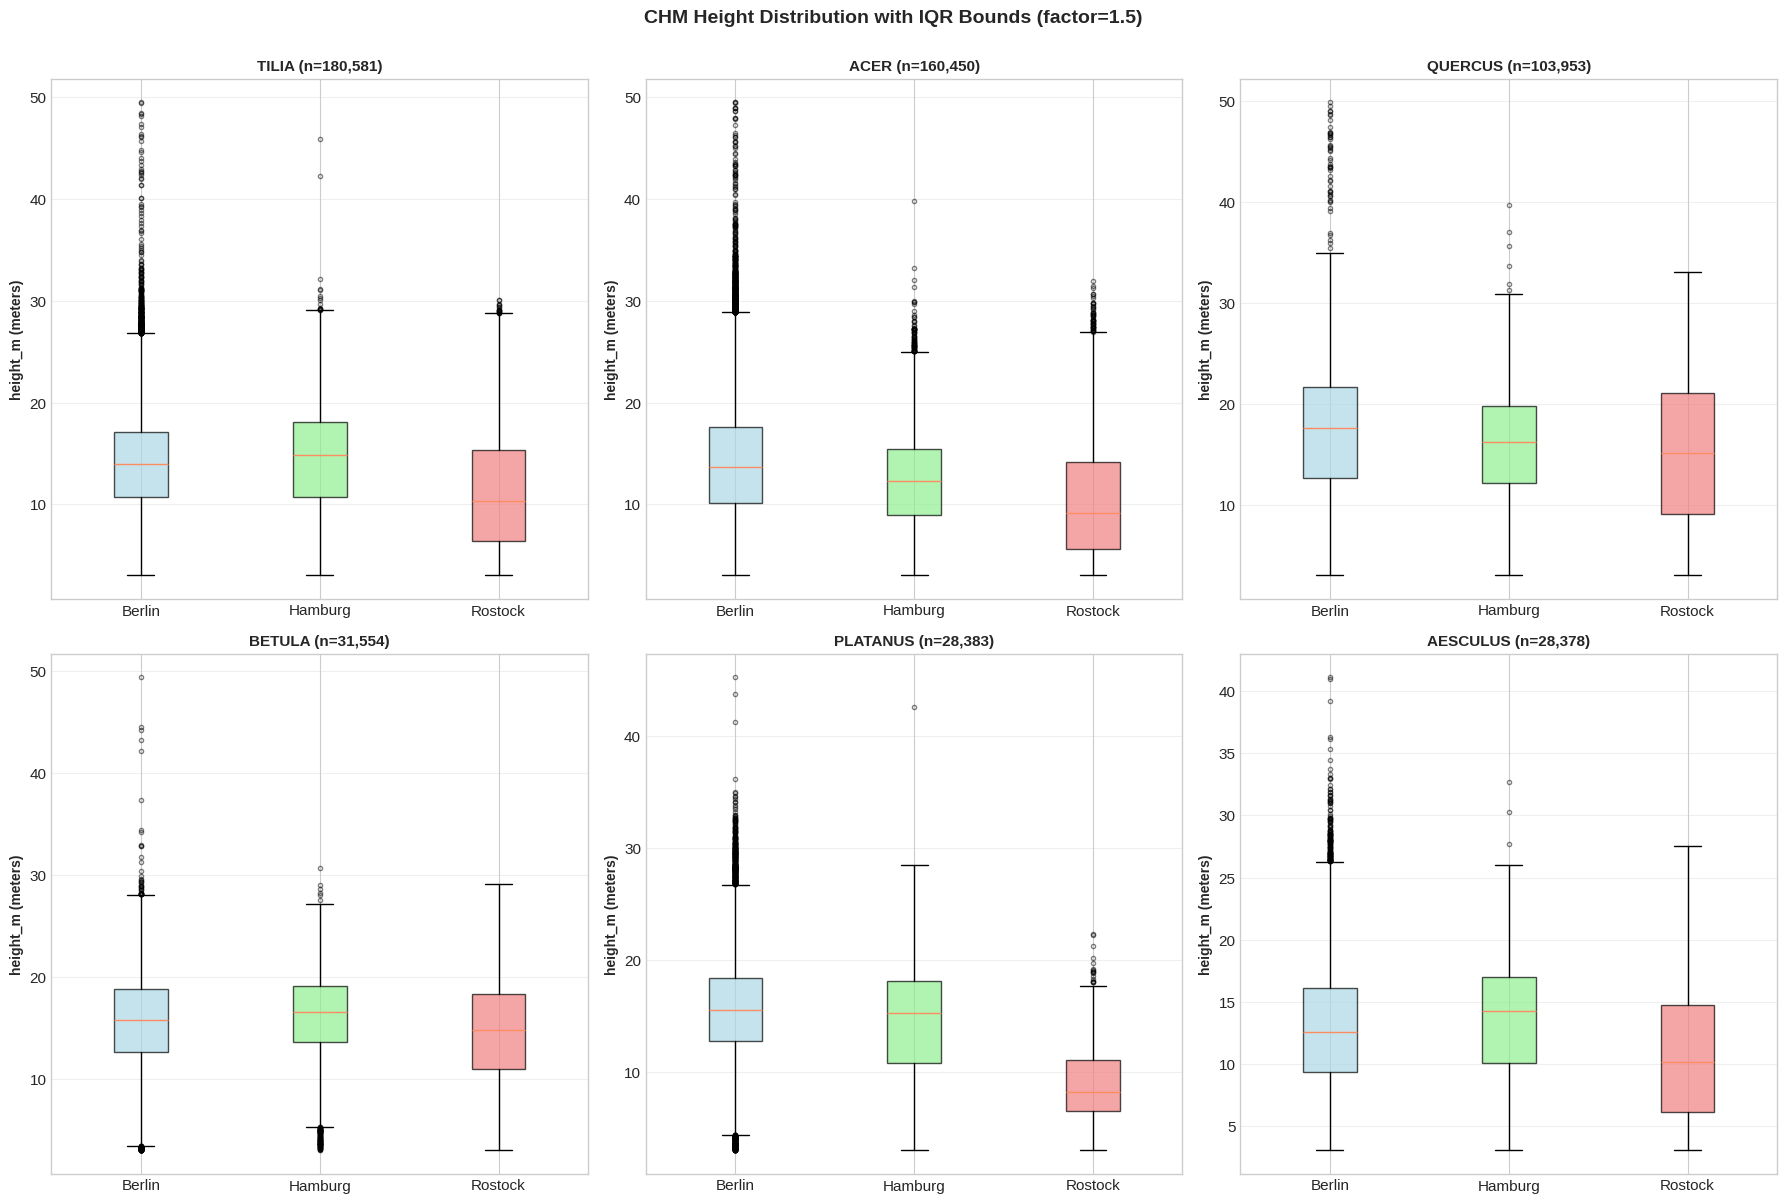

✓ CHM boxplot visualization saved


In [14]:
# Plot CHM distribution for top 6 genera
top_genera = trees_no_edge['genus_latin'].value_counts().head(6).index

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, genus in enumerate(top_genera):
    ax = axes[idx]

    # Data per city
    genus_data = trees_no_edge[trees_no_edge['genus_latin'] == genus]

    # Boxplot
    data_to_plot = [genus_data[genus_data['city'] == city]['height_m'].dropna()
                   for city in sorted(genus_data['city'].unique())]
    cities = sorted(genus_data['city'].unique())

    bp = ax.boxplot(data_to_plot, labels=cities, patch_artist=True,
                    showfliers=True, whis=CHM_IQR_FACTOR)

    # Color boxes
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors[:len(cities)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    # Mark outliers in red
    for flier in bp['fliers']:
        flier.set(marker='o', color='red', alpha=0.5, markersize=3)

    ax.set_ylabel('height_m (meters)', fontsize=10, fontweight='bold')
    ax.set_title(f'{genus} (n={len(genus_data):,})',
                fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'CHM Height Distribution with IQR Bounds (factor={CHM_IQR_FACTOR})',
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUTPUT_FIGURES_DIR / 'outlier_chm_boxplots.png',
           dpi=300, bbox_inches='tight')
plt.show()

print("✓ CHM boxplot visualization saved")

---

## 7. PHASE 5: HIERARCHICAL DECISION LOGIC

### 7.1 Combine Three Flags into Outlier Levels

In [15]:
def apply_hierarchical_decision(df):
    """
    Apply hierarchical outlier decision logic.

    Levels:
    - CRITICAL: mahalanobis & (zscore | chm) → REMOVE
    - HIGH: 2-of-3 flags (not CRITICAL) → FLAG, KEEP
    - MEDIUM: exactly 1 flag → FLAG, KEEP
    - CLEAN: no flags → KEEP

    Returns:
        pd.Series: Outlier level for each tree
    """
    print(f"\n{'='*60}")
    print(f"HIERARCHICAL OUTLIER DECISION LOGIC")
    print(f"{'='*60}\n")

    outlier_level = pd.Series('CLEAN', index=df.index)

    # CRITICAL: Mahalanobis + (Z-Score OR CHM)
    critical_mask = (
        df['mahalanobis_outlier'] &
        (df['zscore_outlier'] | df['chm_outlier'])
    )
    outlier_level.loc[critical_mask] = 'CRITICAL'

    # HIGH: 2-of-3 flags (but not CRITICAL)
    flag_sum = (
        df['zscore_outlier'].astype(int) +
        df['mahalanobis_outlier'].astype(int) +
        df['chm_outlier'].astype(int)
    )
    high_mask = (flag_sum >= 2) & ~critical_mask
    outlier_level.loc[high_mask] = 'HIGH'

    # MEDIUM: exactly 1 flag
    medium_mask = flag_sum == 1
    outlier_level.loc[medium_mask] = 'MEDIUM'

    # Statistics
    print(f"  Outlier Level Distribution:\n")
    for level in ['CRITICAL', 'HIGH', 'MEDIUM', 'CLEAN']:
        count = (outlier_level == level).sum()
        pct = (count / len(df)) * 100
        action = 'REMOVE' if level == 'CRITICAL' else 'KEEP'
        print(f"    {level:8s}: {count:7,} ({pct:5.2f}%) → {action}")

    return outlier_level


# Apply to both datasets
trees_no_edge['outlier_level'] = apply_hierarchical_decision(trees_no_edge)
trees_20m_edge['outlier_level'] = apply_hierarchical_decision(trees_20m_edge)


HIERARCHICAL OUTLIER DECISION LOGIC

  Outlier Level Distribution:

    CRITICAL:  11,785 ( 1.65%) → REMOVE
    HIGH    :      13 ( 0.00%) → KEEP
    MEDIUM  :  64,217 ( 8.99%) → KEEP
    CLEAN   : 638,661 (89.36%) → KEEP

HIERARCHICAL OUTLIER DECISION LOGIC

  Outlier Level Distribution:

    CRITICAL:   5,164 ( 1.78%) → REMOVE
    HIGH    :      12 ( 0.00%) → KEEP
    MEDIUM  :  28,223 ( 9.75%) → KEEP
    CLEAN   : 256,126 (88.46%) → KEEP


### 7.2 Visualize Overlap of Three Methods (Venn Diagram)

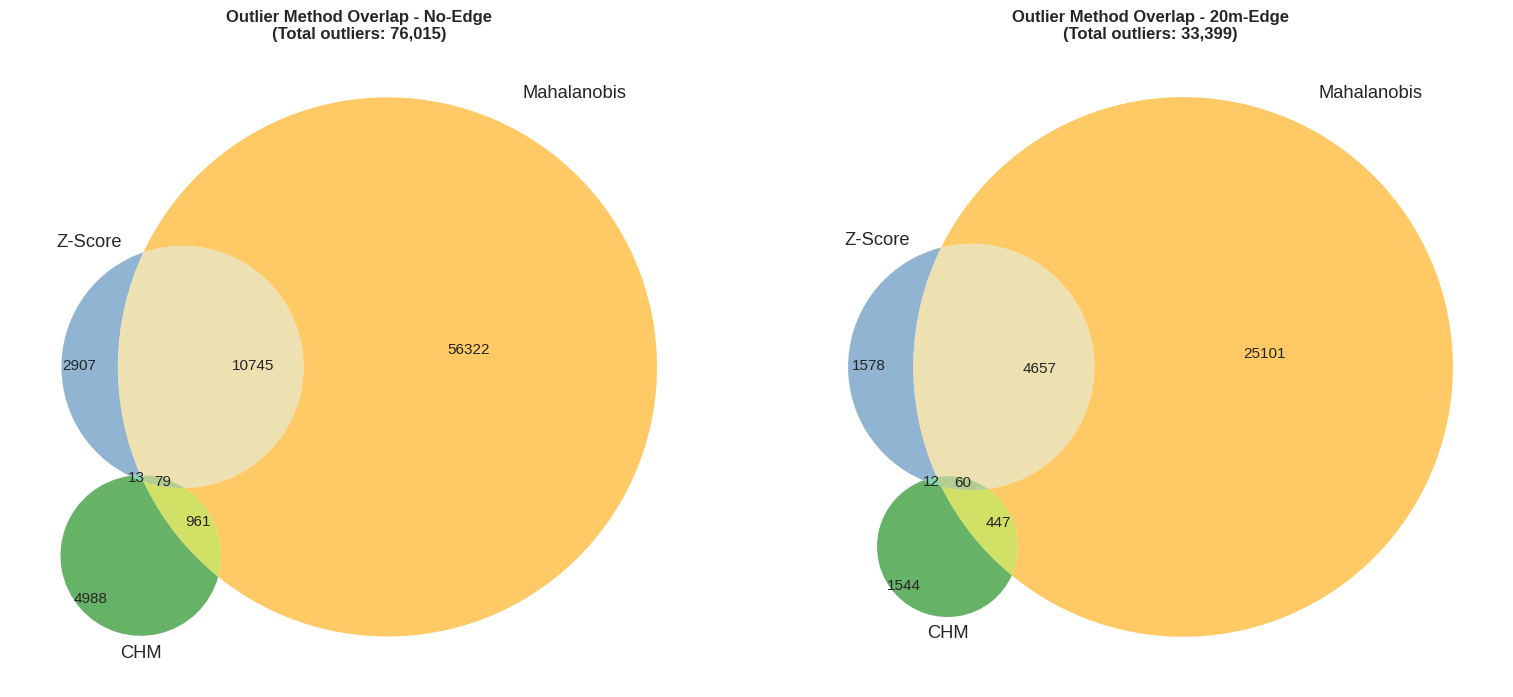

✓ Venn diagram saved


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for idx, (df, title) in enumerate([(trees_no_edge, 'No-Edge'),
                                    (trees_20m_edge, '20m-Edge')]):
    ax = axes[idx]

    # Count overlaps
    only_z = (df['zscore_outlier'] & ~df['mahalanobis_outlier'] & ~df['chm_outlier']).sum()
    only_m = (~df['zscore_outlier'] & df['mahalanobis_outlier'] & ~df['chm_outlier']).sum()
    only_c = (~df['zscore_outlier'] & ~df['mahalanobis_outlier'] & df['chm_outlier']).sum()

    z_and_m = (df['zscore_outlier'] & df['mahalanobis_outlier'] & ~df['chm_outlier']).sum()
    z_and_c = (df['zscore_outlier'] & ~df['mahalanobis_outlier'] & df['chm_outlier']).sum()
    m_and_c = (~df['zscore_outlier'] & df['mahalanobis_outlier'] & df['chm_outlier']).sum()

    all_three = (df['zscore_outlier'] & df['mahalanobis_outlier'] & df['chm_outlier']).sum()

    # Venn diagram
    venn = venn3(subsets=(only_z, only_m, z_and_m, only_c, z_and_c, m_and_c, all_three),
                set_labels=('Z-Score', 'Mahalanobis', 'CHM'),
                ax=ax,
                set_colors=('steelblue', 'orange', 'green'),
                alpha=0.6)

    ax.set_title(f'Outlier Method Overlap - {title}\n'
                f'(Total outliers: {(only_z+only_m+only_c+z_and_m+z_and_c+m_and_c+all_three):,})',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES_DIR / 'outlier_venn_diagram.png',
           dpi=300, bbox_inches='tight')
plt.show()

print("✓ Venn diagram saved")

### 7.3 Remove CRITICAL Outliers

In [17]:
print(f"\n{'='*60}")
print("REMOVING CRITICAL OUTLIERS")
print(f"{'='*60}\n")

# Count before
before_no = len(trees_no_edge)
before_20m = len(trees_20m_edge)

# Filter out CRITICAL
trees_no_edge_clean = trees_no_edge[trees_no_edge['outlier_level'] != 'CRITICAL'].copy()
trees_20m_edge_clean = trees_20m_edge[trees_20m_edge['outlier_level'] != 'CRITICAL'].copy()

# Count after
after_no = len(trees_no_edge_clean)
after_20m = len(trees_20m_edge_clean)

print(f"No-Edge Dataset:")
print(f"  Before: {before_no:,} trees")
print(f"  Removed: {before_no - after_no:,} CRITICAL outliers ({(before_no-after_no)/before_no*100:.2f}%)")
print(f"  After: {after_no:,} trees")

print(f"\n20m-Edge Dataset:")
print(f"  Before: {before_20m:,} trees")
print(f"  Removed: {before_20m - after_20m:,} CRITICAL outliers ({(before_20m-after_20m)/before_20m*100:.2f}%)")
print(f"  After: {after_20m:,} trees")

# Memory cleanup
del trees_no_edge, trees_20m_edge
gc.collect()
print("\n✓ Memory cleaned")


REMOVING CRITICAL OUTLIERS

No-Edge Dataset:
  Before: 714,676 trees
  Removed: 11,785 CRITICAL outliers (1.65%)
  After: 702,891 trees

20m-Edge Dataset:
  Before: 289,525 trees
  Removed: 5,164 CRITICAL outliers (1.78%)
  After: 284,361 trees

✓ Memory cleaned


---

## 8. PHASE 6: SAMPLE SIZE FILTERING

### 8.1 Count Trees per Genus (After Outlier Removal)

In [18]:
def analyze_sample_sizes(df, min_total=MIN_TOTAL_PER_GENUS, min_per_city=MIN_PER_CITY):
    """
    Analyze sample sizes per genus and city.

    Returns:
        pd.DataFrame: Sample counts per genus & city + viability decision
    """
    print(f"\n{'='*60}")
    print(f"SAMPLE SIZE ANALYSIS")
    print(f"{'='*60}\n")

    print(f"  Thresholds:")
    print(f"    Min total per genus: {min_total}")
    print(f"    Min per city: {min_per_city}")
    print(f"\n  Per-Genus Counts:\n")

    sample_stats = []

    for genus in sorted(df['genus_latin'].unique()):
        genus_data = df[df['genus_latin'] == genus]
        total = len(genus_data)

        # Count per city
        city_counts = {}
        for city in sorted(df['city'].unique()):
            city_counts[city] = len(genus_data[genus_data['city'] == city])

        # Viability check
        total_viable = total >= min_total
        city_viable = all(count >= min_per_city for count in city_counts.values() if count > 0)

        # Decision
        if not total_viable:
            decision = 'REMOVE'
            reason = f'Total {total} < {min_total}'
        elif not city_viable:
            decision = 'REMOVE'
            low_cities = [city for city, count in city_counts.items()
                         if 0 < count < min_per_city]
            reason = f'{low_cities[0]} has {city_counts[low_cities[0]]} < {min_per_city}'
        else:
            decision = 'KEEP'
            reason = 'Viable'

        sample_stats.append({
            'genus': genus,
            'total': total,
            **city_counts,
            'decision': decision,
            'reason': reason
        })

        # Print
        city_str = ' | '.join([f"{city}={count:,}" for city, count in city_counts.items()])
        status = '✓' if decision == 'KEEP' else '✗'
        print(f"    {status} {genus:12s}: Total={total:7,} | {city_str} | {decision}")

    return pd.DataFrame(sample_stats)


# Analyze both datasets
sample_stats_no = analyze_sample_sizes(trees_no_edge_clean)
sample_stats_20m = analyze_sample_sizes(trees_20m_edge_clean)


SAMPLE SIZE ANALYSIS

  Thresholds:
    Min total per genus: 1500
    Min per city: 500

  Per-Genus Counts:

    ✓ ACER        : Total=158,149 | Berlin=137,084 | Hamburg=13,445 | Rostock=7,620 | KEEP
    ✓ AESCULUS    : Total= 27,992 | Berlin=24,174 | Hamburg=2,952 | Rostock=866 | KEEP
    ✓ ALNUS       : Total=  7,202 | Berlin=4,703 | Hamburg=1,640 | Rostock=859 | KEEP
    ✓ BETULA      : Total= 31,120 | Berlin=21,663 | Hamburg=4,522 | Rostock=4,935 | KEEP
    ✓ CARPINUS    : Total= 24,076 | Berlin=18,493 | Hamburg=4,920 | Rostock=663 | KEEP
    ✗ CORYLUS     : Total=  9,016 | Berlin=7,013 | Hamburg=1,679 | Rostock=324 | REMOVE
    ✗ CRATAEGUS   : Total=  6,268 | Berlin=5,050 | Hamburg=895 | Rostock=323 | REMOVE
    ✓ FAGUS       : Total= 12,989 | Berlin=10,314 | Hamburg=1,449 | Rostock=1,226 | KEEP
    ✓ FRAXINUS    : Total= 21,317 | Berlin=17,025 | Hamburg=2,577 | Rostock=1,715 | KEEP
    ✗ MALUS       : Total=  3,843 | Berlin=3,036 | Hamburg=522 | Rostock=285 | REMOVE
    ✗ PLATA

### 8.2 Remove Non-Viable Genera

In [19]:
print(f"\n{'='*60}")
print("APPLYING SAMPLE SIZE FILTER")
print(f"{'='*60}\n")

# Identify viable genera
viable_genera_no = sample_stats_no[sample_stats_no['decision'] == 'KEEP']['genus'].tolist()
viable_genera_20m = sample_stats_20m[sample_stats_20m['decision'] == 'KEEP']['genus'].tolist()

# Filter datasets
before_filter_no = len(trees_no_edge_clean)
before_filter_20m = len(trees_20m_edge_clean)

trees_no_edge_final = trees_no_edge_clean[
    trees_no_edge_clean['genus_latin'].isin(viable_genera_no)
].copy()

trees_20m_edge_final = trees_20m_edge_clean[
    trees_20m_edge_clean['genus_latin'].isin(viable_genera_20m)
].copy()

# Statistics
removed_genera_no = set(trees_no_edge_clean['genus_latin'].unique()) - set(viable_genera_no)
removed_genera_20m = set(trees_20m_edge_clean['genus_latin'].unique()) - set(viable_genera_20m)

print(f"No-Edge Dataset:")
print(f"  Before filter: {before_filter_no:,} trees, {len(trees_no_edge_clean['genus_latin'].unique())} genera")
if removed_genera_no:
    print(f"  Removed genera: {', '.join(sorted(removed_genera_no))}")
print(f"  After filter: {len(trees_no_edge_final):,} trees, {len(viable_genera_no)} genera")
print(f"  Final genera: {', '.join(sorted(viable_genera_no))}")

print(f"\n20m-Edge Dataset:")
print(f"  Before filter: {before_filter_20m:,} trees, {len(trees_20m_edge_clean['genus_latin'].unique())} genera")
if removed_genera_20m:
    print(f"  Removed genera: {', '.join(sorted(removed_genera_20m))}")
print(f"  After filter: {len(trees_20m_edge_final):,} trees, {len(viable_genera_20m)} genera")
print(f"  Final genera: {', '.join(sorted(viable_genera_20m))}")

# Memory cleanup
del trees_no_edge_clean, trees_20m_edge_clean
gc.collect()
print("\n✓ Sample size filtering complete")


APPLYING SAMPLE SIZE FILTER

No-Edge Dataset:
  Before filter: 702,891 trees, 19 genera
  Removed genera: CORYLUS, CRATAEGUS, MALUS, PLATANUS, SALIX, ULMUS
  After filter: 635,688 trees, 13 genera
  Final genera: ACER, AESCULUS, ALNUS, BETULA, CARPINUS, FAGUS, FRAXINUS, POPULUS, PRUNUS, QUERCUS, ROBINIA, SORBUS, TILIA

20m-Edge Dataset:
  Before filter: 284,361 trees, 19 genera
  Removed genera: AESCULUS, ALNUS, CARPINUS, CORYLUS, CRATAEGUS, FAGUS, MALUS, PLATANUS, POPULUS, PRUNUS, ROBINIA, SALIX, ULMUS
  After filter: 221,783 trees, 6 genera
  Final genera: ACER, BETULA, FRAXINUS, QUERCUS, SORBUS, TILIA

✓ Sample size filtering complete


---

## 9. PHASE 7: FINAL VALIDATION & SUMMARY

### 9.1 Final Dataset Statistics

In [20]:
print(f"\n{'='*60}")
print("FINAL DATASET SUMMARY")
print(f"{'='*60}\n")

for df, name in [(trees_no_edge_final, 'No-Edge'),
                 (trees_20m_edge_final, '20m-Edge')]:
    print(f"{name} Dataset:")
    print(f"  Total trees: {len(df):,}")
    print(f"  Genera: {df['genus_latin'].nunique()}")
    print(f"  Features: {len([col for col in df.columns if col not in metadata_cols])}")
    print(f"  Cities: {', '.join(sorted(df['city'].unique()))}")

    # Genus statistics
    genus_counts = df['genus_latin'].value_counts()
    print(f"\n  Genus Distribution:")
    print(f"    Largest: {genus_counts.index[0]} ({genus_counts.iloc[0]:,} trees)")
    print(f"    Smallest: {genus_counts.index[-1]} ({genus_counts.iloc[-1]:,} trees)")
    print(f"    Imbalance ratio: {genus_counts.iloc[0] / genus_counts.iloc[-1]:.1f}:1")

    # Outlier flags (kept in dataset)
    print(f"\n  Outlier Flags (retained for analysis):")
    print(f"    HIGH: {(df['outlier_level'] == 'HIGH').sum():,} trees")
    print(f"    MEDIUM: {(df['outlier_level'] == 'MEDIUM').sum():,} trees")
    print(f"    CLEAN: {(df['outlier_level'] == 'CLEAN').sum():,} trees")
    print(f"\n" + "="*60 + "\n")


FINAL DATASET SUMMARY

No-Edge Dataset:
  Total trees: 635,688
  Genera: 13
  Features: 153
  Cities: Berlin, Hamburg, Rostock

  Genus Distribution:
    Largest: TILIA (177,230 trees)
    Smallest: ALNUS (7,202 trees)
    Imbalance ratio: 24.6:1

  Outlier Flags (retained for analysis):
    HIGH: 5 trees
    MEDIUM: 56,156 trees
    CLEAN: 579,527 trees


20m-Edge Dataset:
  Total trees: 221,783
  Genera: 6
  Features: 153
  Cities: Berlin, Hamburg, Rostock

  Genus Distribution:
    Largest: TILIA (111,531 trees)
    Smallest: SORBUS (3,612 trees)
    Imbalance ratio: 30.9:1

  Outlier Flags (retained for analysis):
    HIGH: 7 trees
    MEDIUM: 20,472 trees
    CLEAN: 201,304 trees




### 9.2 Genus Distribution Table

In [21]:
# Create genus distribution table (no-edge)
genus_dist = []

for genus in sorted(trees_no_edge_final['genus_latin'].unique()):
    genus_data = trees_no_edge_final[trees_no_edge_final['genus_latin'] == genus]

    row = {'genus': genus}
    for city in sorted(trees_no_edge_final['city'].unique()):
        row[city] = len(genus_data[genus_data['city'] == city])
    row['total'] = len(genus_data)

    genus_dist.append(row)

genus_dist_df = pd.DataFrame(genus_dist).sort_values('total', ascending=False)

print("\nGenus Distribution (No-Edge):")
print(genus_dist_df.to_string(index=False))


Genus Distribution (No-Edge):
   genus  Berlin  Hamburg  Rostock  total
   TILIA  143733    24398     9099 177230
    ACER  137084    13445     7620 158149
 QUERCUS   73288    24853     4511 102652
  BETULA   21663     4522     4935  31120
AESCULUS   24174     2952      866  27992
 ROBINIA   23392     1166      822  25380
CARPINUS   18493     4920      663  24076
 POPULUS   18375     1068     2031  21474
FRAXINUS   17025     2577     1715  21317
  PRUNUS   12987     2882     1435  17304
   FAGUS   10314     1449     1226  12989
  SORBUS    4452     3324     1027   8803
   ALNUS    4703     1640      859   7202


### 9.3 Visualize Final Genus Distribution

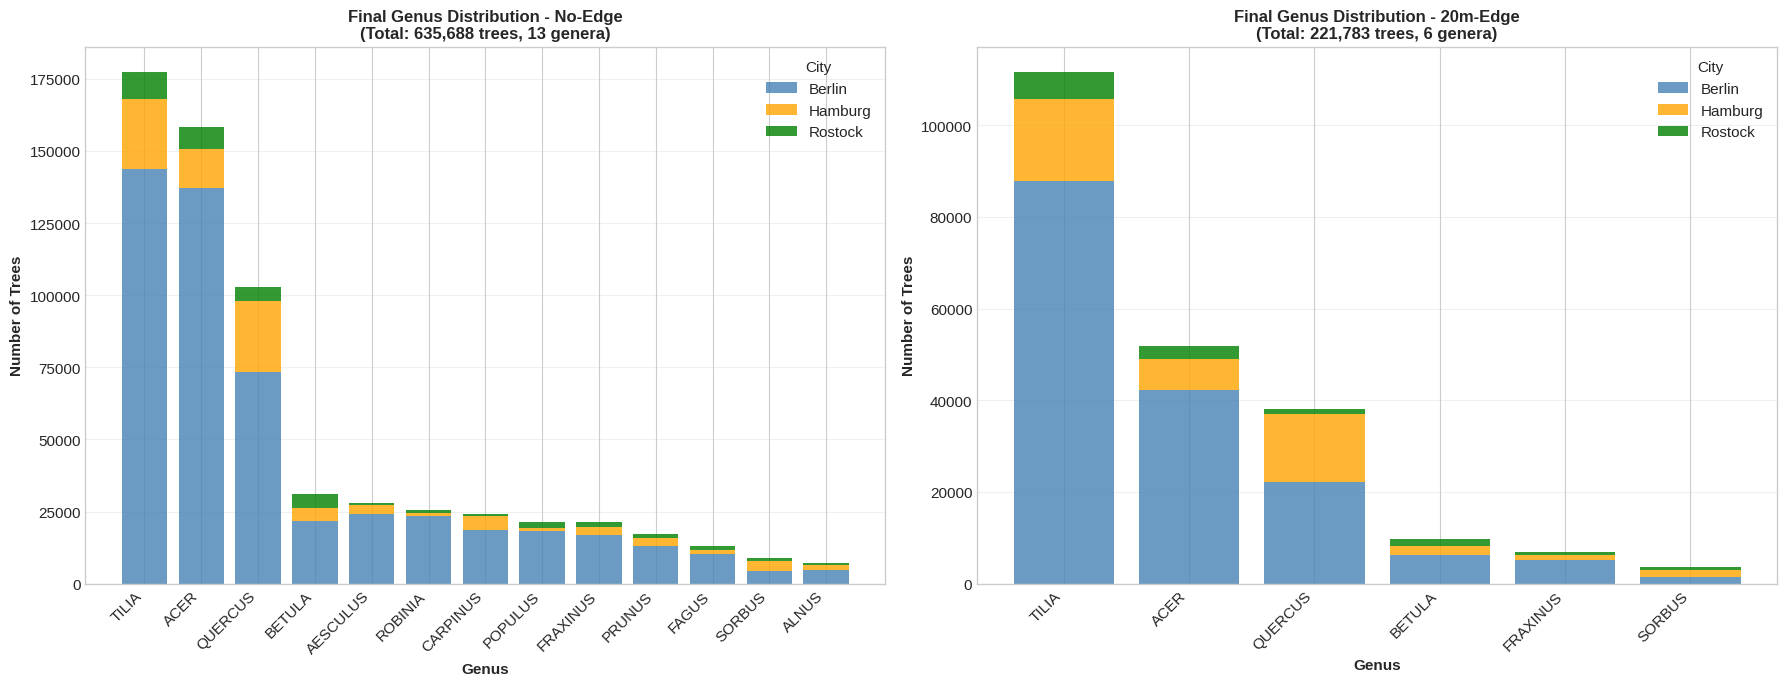

✓ Genus distribution plot saved


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for idx, (df, title) in enumerate([(trees_no_edge_final, 'No-Edge'),
                                    (trees_20m_edge_final, '20m-Edge')]):
    ax = axes[idx]

    # Prepare data for stacked bar
    genera = df['genus_latin'].value_counts().index
    cities = sorted(df['city'].unique())

    data_dict = {city: [] for city in cities}

    for genus in genera:
        for city in cities:
            count = len(df[(df['genus_latin'] == genus) & (df['city'] == city)])
            data_dict[city].append(count)

    # Stacked bar chart
    x = np.arange(len(genera))
    width = 0.8
    bottom = np.zeros(len(genera))

    colors = ['steelblue', 'orange', 'green']
    for city, color in zip(cities, colors):
        ax.bar(x, data_dict[city], width, label=city,
              bottom=bottom, color=color, alpha=0.8)
        bottom += data_dict[city]

    ax.set_xticks(x)
    ax.set_xticklabels(genera, rotation=45, ha='right')
    ax.set_xlabel('Genus', fontsize=11, fontweight='bold')
    ax.set_ylabel('Number of Trees', fontsize=11, fontweight='bold')
    ax.set_title(f'Final Genus Distribution - {title}\n'
                f'(Total: {len(df):,} trees, {len(genera)} genera)',
                fontsize=12, fontweight='bold')
    ax.legend(title='City', loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES_DIR / 'genus_distribution_final.png',
           dpi=300, bbox_inches='tight')
plt.show()

print("✓ Genus distribution plot saved")

### 9.4 Final Data Quality Checks

In [23]:
print("\nFinal Data Quality Checks:\n")

for df, name in [(trees_no_edge_final, 'No-Edge'),
                 (trees_20m_edge_final, '20m-Edge')]:
    print(f"{name}:")

    # Check 1: No NaNs in features
    feature_cols = [col for col in df.columns if col not in metadata_cols]
    nan_count = df[feature_cols].isna().sum().sum()
    assert nan_count == 0, f"ERROR: {nan_count} NaN values found!"
    print(f"  ✓ No NaN values in {len(feature_cols)} features")

    # Check 2: All genera meet minimum sample size
    genus_counts = df['genus_latin'].value_counts()
    assert (genus_counts >= MIN_TOTAL_PER_GENUS).all(), "ERROR: Genus below threshold!"
    print(f"  ✓ All {len(genus_counts)} genera ≥ {MIN_TOTAL_PER_GENUS} samples")

    # Check 3: Dataset not empty
    assert len(df) > 0, "ERROR: Empty dataset!"
    print(f"  ✓ Dataset contains {len(df):,} trees")

    # Check 4: Outlier flags present
    assert 'outlier_level' in df.columns, "ERROR: Missing outlier_level column!"
    print(f"  ✓ Outlier flags present (levels: {df['outlier_level'].unique()})")

    print()

print("✓ All data quality checks passed!")


Final Data Quality Checks:

No-Edge:
  ✓ No NaN values in 153 features
  ✓ All 13 genera ≥ 1500 samples
  ✓ Dataset contains 635,688 trees
  ✓ Outlier flags present (levels: ['CLEAN' 'MEDIUM' 'HIGH'])

20m-Edge:
  ✓ No NaN values in 153 features
  ✓ All 6 genera ≥ 1500 samples
  ✓ Dataset contains 221,783 trees
  ✓ Outlier flags present (levels: ['CLEAN' 'MEDIUM' 'HIGH'])

✓ All data quality checks passed!


---

## 10. PHASE 8: EXPORT

### 10.1 Export Training-Ready GeoPackages

In [24]:
print(f"\n{'='*60}")
print("EXPORT: Training-ready datasets")
print(f"{'='*60}\n")

# Export no-edge (Locally first)
output_no_edge = OUTPUT_DATA_DIR / 'trees_final_no_edge.gpkg'
trees_no_edge_final.to_file(output_no_edge, driver='GPKG')
print(f"✓ Exported (Local): {output_no_edge.name}")

# Copy to Drive
shutil.copy(output_no_edge, DRIVE_OUTPUT_DATA_DIR / output_no_edge.name)
print(f"✓ Copied to Drive: {DRIVE_OUTPUT_DATA_DIR / output_no_edge.name}")

print(f"  Trees: {len(trees_no_edge_final):,}")
print(f"  Genera: {trees_no_edge_final['genus_latin'].nunique()}")
print(f"  Features: {len([col for col in trees_no_edge_final.columns if col not in metadata_cols])}")

# Export 20m-edge (Locally first)
output_20m_edge = OUTPUT_DATA_DIR / 'trees_final_20m_edge.gpkg'
trees_20m_edge_final.to_file(output_20m_edge, driver='GPKG')
print(f"\n✓ Exported (Local): {output_20m_edge.name}")

# Copy to Drive
shutil.copy(output_20m_edge, DRIVE_OUTPUT_DATA_DIR / output_20m_edge.name)
print(f"✓ Copied to Drive: {DRIVE_OUTPUT_DATA_DIR / output_20m_edge.name}")

print(f"  Trees: {len(trees_20m_edge_final):,}")
print(f"  Genera: {trees_20m_edge_final['genus_latin'].nunique()}")
print(f"  Features: {len([col for col in trees_20m_edge_final.columns if col not in metadata_cols])}")


EXPORT: Training-ready datasets

✓ Exported (Local): trees_final_no_edge.gpkg
✓ Copied to Drive: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/04_feature_reduction/05_outlier_detection/data/trees_final_no_edge.gpkg
  Trees: 635,688
  Genera: 13
  Features: 153

✓ Exported (Local): trees_final_20m_edge.gpkg
✓ Copied to Drive: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/04_feature_reduction/05_outlier_detection/data/trees_final_20m_edge.gpkg
  Trees: 221,783
  Genera: 6
  Features: 153


### 10.2 Export Metadata & Reports

In [25]:
print("\nExporting metadata...\n")

# 1. Outlier Detection Report (JSON)
outlier_report = {
    'processing_date': datetime.now().isoformat(),
    'configuration': {
        'zscore_threshold': ZSCORE_THRESHOLD,
        'zscore_min_features': ZSCORE_MIN_FEATURES,
        'mahalanobis_alpha': MAHALANOBIS_ALPHA,
        'chm_iqr_factor': CHM_IQR_FACTOR,
        'spectral_features': len(spectral_cols),
        'chm_features': chm_cols
    },
    'no_edge': {
        'zscore_outliers': int(trees_no_edge_final['zscore_outlier'].sum()),
        'mahalanobis_outliers': int(trees_no_edge_final['mahalanobis_outlier'].sum()),
        'chm_outliers': int(trees_no_edge_final['chm_outlier'].sum()),
        'critical_removed': before_no - after_no,
        'outlier_levels': trees_no_edge_final['outlier_level'].value_counts().to_dict()
    },
    '20m_edge': {
        'zscore_outliers': int(trees_20m_edge_final['zscore_outlier'].sum()),
        'mahalanobis_outliers': int(trees_20m_edge_final['mahalanobis_outlier'].sum()),
        'chm_outliers': int(trees_20m_edge_final['chm_outlier'].sum()),
        'critical_removed': before_20m - after_20m,
        'outlier_levels': trees_20m_edge_final['outlier_level'].value_counts().to_dict()
    }
}

outlier_report_path = OUTPUT_METADATA_DIR / 'outlier_detection_report.json'
with open(outlier_report_path, 'w') as f:
    json.dump(outlier_report, f, indent=2)
print(f"✓ Exported: {outlier_report_path.name}")

# 2. Sample Size Filter Report (CSV)
sample_stats_no['dataset'] = 'no_edge'
sample_stats_20m['dataset'] = '20m_edge'
sample_stats_combined = pd.concat([sample_stats_no, sample_stats_20m], ignore_index=True)

sample_report_path = OUTPUT_METADATA_DIR / 'sample_size_filter_report.csv'
sample_stats_combined.to_csv(sample_report_path, index=False)
print(f"✓ Exported: {sample_report_path.name}")

# 3. Final Dataset Summary (JSON)
final_summary = {
    'processing_date': datetime.now().isoformat(),
    'no_edge': {
        'trees': len(trees_no_edge_final),
        'genera': trees_no_edge_final['genus_latin'].nunique(),
        'genera_list': sorted(trees_no_edge_final['genus_latin'].unique().tolist()),
        'features': len([col for col in trees_no_edge_final.columns if col not in metadata_cols]),
        'class_imbalance_ratio': float(genus_dist_df.iloc[0]['total'] / genus_dist_df.iloc[-1]['total'])
    },
    '20m_edge': {
        'trees': len(trees_20m_edge_final),
        'genera': trees_20m_edge_final['genus_latin'].nunique(),
        'genera_list': sorted(trees_20m_edge_final['genus_latin'].unique().tolist()),
        'features': len([col for col in trees_20m_edge_final.columns if col not in metadata_cols]),
        'class_imbalance_ratio': float(
            trees_20m_edge_final['genus_latin'].value_counts().iloc[0] /
            trees_20m_edge_final['genus_latin'].value_counts().iloc[-1]
        )
    },
    'sample_size_thresholds': {
        'min_total_per_genus': MIN_TOTAL_PER_GENUS,
        'min_per_city': MIN_PER_CITY
    }
}

final_summary_path = OUTPUT_METADATA_DIR / 'final_dataset_summary.json'
with open(final_summary_path, 'w') as f:
    json.dump(final_summary, f, indent=2)
print(f"✓ Exported: {final_summary_path.name}")

print(f"\n{'='*60}")
print("OUTLIER DETECTION & FILTERING COMPLETE")
print(f"{'='*60}")
print(f"\nOutputs saved to: {OUTPUT_DATA_DIR}")
print(f"  Data: 2 GeoPackages (trees_final_*.gpkg) → **TRAINING-READY**")
print(f"  Metadata: 3 files (JSON×2, CSV×1)")
print(f"  Figures: {len(list(OUTPUT_FIGURES_DIR.glob('*.png')))} visualizations")
print(f"\n✓ Ready for modeling: Phase 4 - Experiments")


Exporting metadata...

✓ Exported: outlier_detection_report.json
✓ Exported: sample_size_filter_report.csv
✓ Exported: final_dataset_summary.json

OUTLIER DETECTION & FILTERING COMPLETE

Outputs saved to: /content/local_data/output
  Data: 2 GeoPackages (trees_final_*.gpkg) → **TRAINING-READY**
  Metadata: 3 files (JSON×2, CSV×1)
  Figures: 5 visualizations

✓ Ready for modeling: Phase 4 - Experiments


---

**Notebook End**

**Next Phase:** Modeling (Experiments 0-5)  
**Input for Modeling:** `trees_final_*.gpkg`

**Key Achievements:**
- Three-method outlier detection (Z-Score, Mahalanobis, CHM IQR)
- Hierarchical decision logic (CRITICAL removed, HIGH/MEDIUM flagged)
- Sample size constraints met (all genera ≥1500 total, ≥500 per city)
- Training-ready datasets with outlier flags retained for experiments
- Conservative removal (~1.5-2.5% CRITICAL outliers only)

**Author:** Silas Pignotti  
**Date:** Januar 2026